# 📝 Pattern Recognition & Biometrics. TP Traitement du Langage Naturel ou *NLP (Natural Language Processing)*

Par Omar Galarraga et Sonia Garcia

(facultatif) Pour vérifier si le hardware sera bien utilisé dans sa totalité pour maximiser les performances.

In [6]:
import torch
import psutil
import platform
import cpuinfo
import wmi
from torch.backends import cudnn


def test_hardware_detection():
    #GPU info
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"GPU: {gpu_name}, Memory: {gpu_memory:.2f} GB, CUDA: {torch.version.cuda}, CuDNN: {torch.backends.cudnn.version()}, Performance: {torch.cuda.get_device_capability(0)}")
    else:
        print("No GPU available")
    #CPU info
    try:
        cpu_info = cpuinfo.get_cpu_info()
        cpu_name = cpu_info['brand_raw']
    except Exception as e:
        cpu_name = platform.processor() or "Unknown CPU"
        print(f"Unable to get detailed CPU info: {e}")
    cpu_cores = psutil.cpu_count(logical=False)
    print(f"CPU: {cpu_name}, Cores: {cpu_cores}, Threads: {psutil.cpu_count()}, Frequency: {psutil.cpu_freq().current:.2f} MHz, Usage: {psutil.cpu_percent()}%")
    
    #RAM info
    w = wmi.WMI()
    ram_speeds = []
    for memory in w.Win32_PhysicalMemory():
        ram_speeds.append(memory.Speed)
    ram_speed_str = ', '.join([f"{speed} MHz" for speed in ram_speeds]) if ram_speeds else "Unknown speed"
    ram_total = psutil.virtual_memory().total / 1024**3
    print(f"RAM: {ram_total:.2f} GB ({psutil.virtual_memory().percent:.2f}% used) @ {ram_speed_str}")

test_hardware_detection()

# Check CUDA version
print(f"CUDA version: {torch.version.cuda}")

# Check cuDNN version
print(f"cuDNN version: {cudnn.version()}")

GPU: NVIDIA GeForce RTX 4090, Memory: 23.99 GB, CUDA: 12.1, CuDNN: 8801, Performance: (8, 9)
CPU: 13th Gen Intel(R) Core(TM) i9-13900K, Cores: 24, Threads: 32, Frequency: 3000.00 MHz, Usage: 0.9%
RAM: 63.76 GB (32.40% used) @ 4800 MHz, 4800 MHz
CUDA version: 12.1
cuDNN version: 8801


In [4]:
import numpy as np
from pprint import pprint
import torch

Dans ce travail pratique, nous constituerons un *pipeline* de traitement du langage naturel avec différents modèles pour analyser le chapitre I du roman "Le Petit Prince" d'Antoine de Saint-Exupéry

In [5]:
def read_text(masked = False, language = 'fr'):
    PATH_MASKED = 'lepetitprince_chap1_masked' + ('_en' if language == 'en' else '') + '.txt'
    PATH_UNMASKED = 'lepetitprince_chap1' + ('_en' if language == 'en' else '') + '.txt'
    path = PATH_MASKED if masked else PATH_UNMASKED
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

In [6]:
#Modifiez votre chemin d'accès si besoin
with open('lepetitprince_chap1.txt', encoding='utf-8') as f:
    sentences = f.readlines()

print(sentences)

['Lorsque j’avais six ans j’ai vu, une fois, une magnifique image, dans un livre sur la Forêt Vierge qui s’appelait « Histoires Vécues ». \n', 'Ça représentait un serpent boa qui avalait un fauve. Voilà la copie du dessin.\n', 'On disait dans le livre : « Les serpents boas avalent leur proie tout entière, sans la mâcher. \n', 'Ensuite ils ne peuvent plus bouger et ils dorment pendant les six mois de leur digestion. »\n', 'J’ai alors beaucoup réfléchi sur les aventures de la jungle et, à mon tour, j’ai réussi, avec un crayon de couleur, à tracer mon premier dessin. \n', 'Mon dessin numéro 1. Il était comme ça :\n', 'J’ai montré mon chef-d’œuvre aux grandes personnes et je leur ai demandé si mon dessin leur faisait peur.\n', 'Elles m’ont répondu : « Pourquoi un chapeau ferait-il peur ? »\n', 'Mon dessin ne représentait pas un chapeau. \n', 'Il représentait un serpent boa qui digérait un éléphant. \n', 'J’ai alors dessiné l’intérieur du serpent boa, afin que les grandes personnes puissent

## Partie I. *Word embeddings* ou la modélisation des mots

Nous utiliserons les libraries *nltk* et *gensim* pour créer des modèles *word2vec*

* I.1) Convertissez le texte (phrases) en tokens
* I.2) Construisez un modèle *CBOW* et un *skip-gram* avec le corpus du livre


In [7]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Skander\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
w2v_cbow = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=0)   #CBOW
w2v_sg = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)     #Skip-gram

* I.3) Quel est le vecteur associé au mot "boa" ? Est-il le même dans les deux modèles (*CBOW* et *skip-gram*) ?
* I.4) Quels mots sont "similaires" au mot "boa" ? Sont-ils les mêmes dans les deux modèles ?

In [9]:
boa_cbow = w2v_cbow.wv['boa']
boa_sg = w2v_sg.wv['boa']
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
similarity = cosine_sim(boa_cbow, boa_sg)
print(f"Similarité entre {'boa avec CBOW'} et {'boa avec skip-gram'} : {similarity}")

Similarité entre boa avec CBOW et boa avec skip-gram : 0.9911512136459351


Pas le même mot mais quasiment le même (au vu de la similarité cosinus proche de 1)

In [10]:
similar_words_boa = w2v_cbow.wv.most_similar('boa')
print(similar_words_boa)

[('carrière', 0.2611195147037506), ('découragé', 0.2579665780067444), ('Chine', 0.24458657205104828), ('au', 0.22318491339683533), ('autre', 0.2174520343542099), ('amélioré', 0.19799433648586273), ('trop', 0.17396698892116547), ('vécu', 0.1704605370759964), ('peu', 0.1681075394153595), ('ne', 0.16546425223350525)]


* I.5) Affichez les graphiques des deux modèles en faisant une réduction de dimension à 2D par t-SNE (voir code d'exemple ci-dessous). Quelles sont les coordonnées en 2D du mot "boa" dans les deux modèles ?

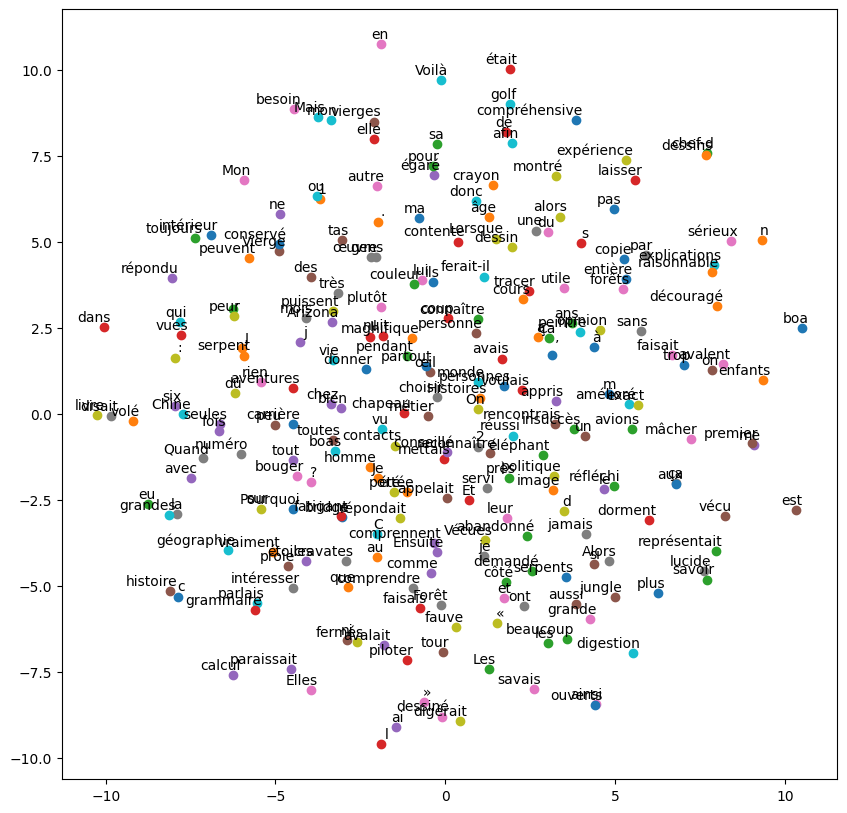

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Affectez le nom de votre modèle Word2Vec à la variable model_w2v ci-dessous
model_w2v = w2v_cbow

# t-SNE pour réduire à 2 dimensions
word_vectors = model_w2v.wv.vectors
num_samples = len(word_vectors)
tsne_perplexity = min(30, num_samples - 1)  # Perplexity must be less than the number of samples

tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the vectors
plt.figure(figsize=(10, 10))
for i, word in enumerate(model_w2v.wv.index_to_key):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.show()

In [12]:
boa_coord = word_vectors_2d[model_w2v.wv.key_to_index['boa']]
print(boa_coord)

[10.498907   2.4891558]


## Partie II. Réseaux de neurones et attention

* II.1) Construisez et entraînez un réseau de neurones dense pour prédire le cinquème token de chaque phrase en fonction des quatre premiers tokens d'un modèle Word2Vec. Quelle est l'erreur d'apprentissage ?
* II.2) Quelle est la dimension de la couche d'entrée ?   On a choisi 4 couches d'entré
* II.3) Quelle est la dimension de la couche de sortie ?
* II.4) Quelle est l'erreur RMS pour la 10ème phrase ?


On en a eu marre d'utiliser tensorflow qui a des incompatibilités avec Windows pour les GPU donc on utilise pytorch maintenant vu que c'est devenu plus utilisé aussi.

In [13]:
def make_samples(tokenized_sentences, context_size = 4):
    X, Y = [], []
    for sentence in tokenized_sentences:
        if len(sentence)>=context_size+1:
            context = sentence[:context_size]
            target = sentence[context_size]
            X.append(context)
            Y.append(target)
    return X, Y

def preprocessing_vectors(context_size = 4):
    X, Y = [], []
    for sentence in tokenized_sentences:
        if len(sentence)>=context_size+1:
            context = [w2v_cbow.wv[word] for word in sentence[:context_size]]
            target = w2v_cbow.wv[sentence[context_size]]
            X.append(context)
            Y.append(target)
    X, Y = np.array(X), np.array(Y)
    X_tensor, Y_tensor = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
    return X_tensor, Y_tensor

X_tensor, Y_tensor = preprocessing_vectors()
print(X_tensor.shape, Y_tensor.shape)     


torch.Size([32, 4, 100]) torch.Size([32, 100])


In [14]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

class DenseNN(nn.Module):
    def __init__(self, input_size=w2v_cbow.vector_size, context_size=4, output_size=w2v_cbow.vector_size, input_neurons=128, hidden_neurons=1024):
        super(DenseNN, self).__init__()
        self.context_size = context_size
        self.fc_layers = nn.ModuleList([nn.Linear(input_size, input_neurons) for _ in range(context_size)])
        self.fc_hidden = nn.Linear(input_neurons * context_size, hidden_neurons)
        self.fc_output = nn.Linear(hidden_neurons, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = [self.relu(self.fc_layers[i](x[:, i, :])) for i in range(self.context_size)]
        out = torch.cat(out, dim=1)
        out = self.relu(self.fc_hidden(out))
        out = self.fc_output(out)
        return out
    
    def fit(self, dataloader : DataLoader, num_epochs=50, lr=0.001):
        self.train()
        criterion = nn.CosineEmbeddingLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(num_epochs):
            epoch_loss = 0
            with tqdm(total=len(dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
                for inputs, targets in dataloader:
                    outputs = self(inputs)
                    labels = torch.ones(outputs.size(0)).to(inputs.device)
                    loss = criterion(outputs, targets, labels)
                    epoch_loss += loss.item()
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    pbar.update(1)
                    pbar.set_postfix(loss=loss.item())
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
        print(f"Final training loss: {epoch_loss/len(dataloader):.4f}")




In [15]:
model = DenseNN()
criterion, optimizer = nn.CosineEmbeddingLoss(), optim.Adam(model.parameters(), lr=0.001)
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
model.fit(dataloader, num_epochs=50, lr=0.002)

Epoch 1/50: 100%|██████████| 32/32 [00:00<00:00, 180.05it/s, loss=0.908]


Epoch [1/50], Loss: 0.9620


Epoch 2/50: 100%|██████████| 32/32 [00:00<00:00, 201.02it/s, loss=1.03] 


Epoch [2/50], Loss: 0.8157


Epoch 3/50: 100%|██████████| 32/32 [00:00<00:00, 200.97it/s, loss=0.884]


Epoch [3/50], Loss: 0.8045


Epoch 4/50: 100%|██████████| 32/32 [00:00<00:00, 214.48it/s, loss=0.877]


Epoch [4/50], Loss: 0.8040


Epoch 5/50: 100%|██████████| 32/32 [00:00<00:00, 175.04it/s, loss=0.941]


Epoch [5/50], Loss: 0.8011


Epoch 6/50: 100%|██████████| 32/32 [00:00<00:00, 175.22it/s, loss=0.874]


Epoch [6/50], Loss: 0.7985


Epoch 7/50: 100%|██████████| 32/32 [00:00<00:00, 178.93it/s, loss=0.875]


Epoch [7/50], Loss: 0.7967


Epoch 8/50: 100%|██████████| 32/32 [00:00<00:00, 179.99it/s, loss=0.722]


Epoch [8/50], Loss: 0.7932


Epoch 9/50: 100%|██████████| 32/32 [00:00<00:00, 173.23it/s, loss=0.725]


Epoch [9/50], Loss: 0.7911


Epoch 10/50: 100%|██████████| 32/32 [00:00<00:00, 159.34it/s, loss=0.943]


Epoch [10/50], Loss: 0.7890


Epoch 11/50: 100%|██████████| 32/32 [00:00<00:00, 171.46it/s, loss=0.719]


Epoch [11/50], Loss: 0.7826


Epoch 12/50: 100%|██████████| 32/32 [00:00<00:00, 177.10it/s, loss=0.76] 


Epoch [12/50], Loss: 0.7580


Epoch 13/50: 100%|██████████| 32/32 [00:00<00:00, 167.38it/s, loss=0.812]


Epoch [13/50], Loss: 0.7352


Epoch 14/50: 100%|██████████| 32/32 [00:00<00:00, 174.74it/s, loss=0.673]


Epoch [14/50], Loss: 0.6990


Epoch 15/50: 100%|██████████| 32/32 [00:00<00:00, 165.92it/s, loss=0.682]


Epoch [15/50], Loss: 0.6592


Epoch 16/50: 100%|██████████| 32/32 [00:00<00:00, 170.06it/s, loss=0.739]


Epoch [16/50], Loss: 0.5919


Epoch 17/50: 100%|██████████| 32/32 [00:00<00:00, 181.69it/s, loss=0.448]


Epoch [17/50], Loss: 0.5176


Epoch 18/50: 100%|██████████| 32/32 [00:00<00:00, 164.78it/s, loss=0.617] 


Epoch [18/50], Loss: 0.4394


Epoch 19/50: 100%|██████████| 32/32 [00:00<00:00, 174.72it/s, loss=0.645] 


Epoch [19/50], Loss: 0.3840


Epoch 20/50: 100%|██████████| 32/32 [00:00<00:00, 166.10it/s, loss=0.274] 


Epoch [20/50], Loss: 0.3291


Epoch 21/50: 100%|██████████| 32/32 [00:00<00:00, 162.20it/s, loss=0.611] 


Epoch [21/50], Loss: 0.2787


Epoch 22/50: 100%|██████████| 32/32 [00:00<00:00, 151.46it/s, loss=0.296] 


Epoch [22/50], Loss: 0.2233


Epoch 23/50: 100%|██████████| 32/32 [00:00<00:00, 117.78it/s, loss=0.106]  


Epoch [23/50], Loss: 0.1930


Epoch 24/50: 100%|██████████| 32/32 [00:00<00:00, 105.23it/s, loss=0.42]  


Epoch [24/50], Loss: 0.1709


Epoch 25/50: 100%|██████████| 32/32 [00:00<00:00, 93.61it/s, loss=0.0184] 


Epoch [25/50], Loss: 0.1413


Epoch 26/50: 100%|██████████| 32/32 [00:00<00:00, 98.04it/s, loss=0.0565]


Epoch [26/50], Loss: 0.1282


Epoch 27/50: 100%|██████████| 32/32 [00:00<00:00, 95.60it/s, loss=0.46]   


Epoch [27/50], Loss: 0.1072


Epoch 28/50: 100%|██████████| 32/32 [00:00<00:00, 106.58it/s, loss=0.00425]


Epoch [28/50], Loss: 0.0906


Epoch 29/50: 100%|██████████| 32/32 [00:00<00:00, 104.81it/s, loss=0.0186] 


Epoch [29/50], Loss: 0.0752


Epoch 30/50: 100%|██████████| 32/32 [00:00<00:00, 103.24it/s, loss=0.216]  


Epoch [30/50], Loss: 0.0705


Epoch 31/50: 100%|██████████| 32/32 [00:00<00:00, 103.57it/s, loss=0.00951]


Epoch [31/50], Loss: 0.0627


Epoch 32/50: 100%|██████████| 32/32 [00:00<00:00, 96.59it/s, loss=0.00579] 


Epoch [32/50], Loss: 0.0507


Epoch 33/50: 100%|██████████| 32/32 [00:00<00:00, 88.65it/s, loss=0.00188]


Epoch [33/50], Loss: 0.0404


Epoch 34/50: 100%|██████████| 32/32 [00:00<00:00, 78.18it/s, loss=0.385]   


Epoch [34/50], Loss: 0.0357


Epoch 35/50: 100%|██████████| 32/32 [00:00<00:00, 73.89it/s, loss=0.00349]


Epoch [35/50], Loss: 0.0313


Epoch 36/50: 100%|██████████| 32/32 [00:00<00:00, 67.25it/s, loss=0.0213] 


Epoch [36/50], Loss: 0.0288


Epoch 37/50: 100%|██████████| 32/32 [00:00<00:00, 65.67it/s, loss=0.00133]


Epoch [37/50], Loss: 0.0285


Epoch 38/50: 100%|██████████| 32/32 [00:00<00:00, 64.51it/s, loss=0.0141]  


Epoch [38/50], Loss: 0.0277


Epoch 39/50: 100%|██████████| 32/32 [00:00<00:00, 66.13it/s, loss=0.00128] 


Epoch [39/50], Loss: 0.0245


Epoch 40/50: 100%|██████████| 32/32 [00:00<00:00, 65.51it/s, loss=0.00232] 


Epoch [40/50], Loss: 0.0243


Epoch 41/50: 100%|██████████| 32/32 [00:00<00:00, 67.32it/s, loss=0.000865]


Epoch [41/50], Loss: 0.0242


Epoch 42/50: 100%|██████████| 32/32 [00:00<00:00, 65.00it/s, loss=0.00111] 


Epoch [42/50], Loss: 0.0262


Epoch 43/50: 100%|██████████| 32/32 [00:00<00:00, 66.82it/s, loss=0.00177] 


Epoch [43/50], Loss: 0.0227


Epoch 44/50: 100%|██████████| 32/32 [00:00<00:00, 65.11it/s, loss=0.000554]


Epoch [44/50], Loss: 0.0222


Epoch 45/50: 100%|██████████| 32/32 [00:00<00:00, 67.38it/s, loss=0.00103] 


Epoch [45/50], Loss: 0.0215


Epoch 46/50: 100%|██████████| 32/32 [00:00<00:00, 65.52it/s, loss=0.00068] 


Epoch [46/50], Loss: 0.0224


Epoch 47/50: 100%|██████████| 32/32 [00:00<00:00, 65.37it/s, loss=0.000933]


Epoch [47/50], Loss: 0.0224


Epoch 48/50: 100%|██████████| 32/32 [00:00<00:00, 64.13it/s, loss=0.371]   


Epoch [48/50], Loss: 0.0228


Epoch 49/50: 100%|██████████| 32/32 [00:00<00:00, 66.95it/s, loss=0.000748]


Epoch [49/50], Loss: 0.0217


Epoch 50/50: 100%|██████████| 32/32 [00:00<00:00, 65.56it/s, loss=0.359]   

Epoch [50/50], Loss: 0.0219
Final training loss: 0.0219


In [16]:
def vec_to_word(vector, w2v_model = w2v_cbow):
    return w2v_model.wv.similar_by_vector(vector, topn=1)[0][0]

def predict_word(context, w2v_model = w2v_cbow, nn_model = model):
    context = np.array([w2v_model.wv[word] for word in context])
    context = torch.tensor(context, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        prediction = nn_model(context)
    return vec_to_word(prediction.squeeze().numpy())

contexts, targets = make_samples(tokenized_sentences)

def accuracy(contexts, targets, w2v_model = w2v_cbow, nn_model = model):
    correct = 0
    for context, target in zip(contexts, targets):
        prediction = predict_word(context, w2v_model, nn_model)
        if prediction == target:
            correct += 1
    return correct / len(contexts)

acc = accuracy(contexts, targets)
print(f"Accuracy: {acc:.2f}")

Accuracy: 0.97


## Partie III. Transformers


Pour cette partie, nous utiliserons le modèle *CamemBERT*, qui est modèle type BERT (Transformer) spécifique à la langue française. Ce modèle est disponible dans la librairie *Transformers* de *HuggingFace* (documentation disponible sur : https://huggingface.co/docs/transformers/model_doc/camembert). Nous travaillerons le fichier 'lepetitprince_chap1_masked.txt', qui contient des mots masqués.

* III.1) "Tokenisez" le texte. Quelle est la dimension du vecteur de modélisation des tokens ?

1 + 2

In [17]:
from transformers import CamembertTokenizer, CamembertForMaskedLM, pipeline

# on est obligé de définir cette fonction pour contourner la limitation de la taille des tokens de CamemBERT qui est de 514
def split_text(text : str, sep="\n"):
    tokens = text.split(sep)
    for i in range(len(tokens)-1):
        tokens[i] += sep
    return tokens


tokenizer = CamembertTokenizer.from_pretrained("camembert/camembert-large")
model = CamembertForMaskedLM.from_pretrained("camembert/camembert-large")

text = split_text(read_text(masked=True, language='fr'))
camembert_fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)

def fill_mask_text(texte):
    s = ""
    for sentence in texte:
        if "<mask>" in sentence:
            masked_sentence = sentence.replace("<mask>", tokenizer.mask_token)
            three_best_results = [camembert_fill_mask(masked_sentence)[k]["token_str"] for k in range(3)]
            filled_sentence = masked_sentence.replace(tokenizer.mask_token, f"{three_best_results}", 1)
            s+=filled_sentence
        else:
            s+=sentence
    return s

filled_text = fill_mask_text(text)
print(filled_text)

Lorsque j’avais six ans j’ai ['vu', 'lu', 'découvert'], une fois, une magnifique image, dans un livre sur la Forêt Vierge qui s’appelait « Histoires Vécues ». 
Ça représentait un serpent ['géant', 'gigantesque', 'énorme'] qui avalait un fauve. Voilà la copie du dessin.
On disait dans le ['passé', 'pays', 'Nord'] : « Les serpents boas avalent leur proie tout entière, sans la mâcher. 
Ensuite ils ne peuvent ['plus', 'pas', 'rien'] bouger et ils dorment pendant les six mois de leur digestion. »
J’ai alors beaucoup réfléchi ['sur', 'devant', 'dans'] les aventures de la jungle et, à mon tour, j’ai réussi, avec un crayon de couleur, à tracer mon premier dessin. 
Mon dessin numéro 1. Il était ['comme', 'à', 'donc'] ça :
J’ai montré mon chef-d’œuvre ['aux', 'des', 'de'] grandes personnes et je leur ai demandé si mon dessin leur faisait peur.
Elles m’ont ['demandé', 'dit', 'répondu'] : « Pourquoi un chapeau ferait-il peur ? »
Mon dessin ne ['porte', 'tient', 'vaut'] pas un chapeau. 
Il représen

* III.2) Prédisez les mots masqués. Donnez les 3 mots les plus probables pour les 10 premières phrases.

## Partie IV. LLM

* IV.I) Réalisez à nouveau la partie III en utilisant cette fois-ci Llama2 ou Mixtral (modèles disponibles dans la librairie *Transformers* de *HuggingFace*). Llama2 est aussi téléchargeable sur https://llama-2.ai/download/
* IV.2) Faites un résumé automatique en 20 mots environ du chapitre I

IV.1) On utilisera Llama-3-8B.

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from accelerate import init_empty_weights, infer_auto_device_map
from torch.utils.tensorboard import SummaryWriter
import torch.profiler as profiler

# Ensure you have the correct versions of the necessary libraries
print(f"PyTorch version: {torch.__version__}")

# Load the tokenizer
model_name = "meta-llama/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize model with empty weights to avoid loading everything into memory at once
with init_empty_weights():
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)

# Define max memory for GPU, ensure to fit it within your GPU's capacity
max_memory = {
    0: "24GiB"
}

# Infer device map to manage memory entirely on the GPU
device_map = infer_auto_device_map(model, max_memory=max_memory)

# Load the model with the device_map
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device_map,
    torch_dtype=torch.float16,
)

# Initialize the pipeline with the model
text_gen = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16  # Use mixed precision to reduce memory usage
)

# TensorBoard writer
writer = SummaryWriter()

# Run inference with profiling
with profiler.profile(
    activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA],
    schedule=profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=profiler.tensorboard_trace_handler('./log_dir'),
    record_shapes=True,
    profile_memory=True,
    with_stack=True,
) as prof:
    with profiler.record_function("model_inference"):
        output = text_gen("Once upon a time there is a cockroach that dies,", max_length=100)
    # Ensure profiler step is finished
    prof.step()

# Print profiling results
print(prof.key_averages().table(sort_by="cuda_time_total"))

# Close the writer
writer.close()
print(output)


PyTorch version: 2.3.0+cu121


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


KeyboardInterrupt: 

: 

IV.2) Pour la partie summarization, on ne peut pas utiliser Llama, il ne fait pas la summarization. On utilise donc t5-large de Google qui est très populaire sur HuggingFace

In [ ]:
from transformers import pipeline

model_name = "google-t5/t5-large"
summarizer = pipeline('summarization', model=model_name, tokenizer=model_name, device=0)
text = read_text(language="en")
summary = summarizer(text, max_length=80, min_length=30)
summarized_text = summary[0]['summary_text']


On choisit un résumé entre 30 et 80 mots et on a préalablement traduit le texte en anglais pour utiliser le modèle T5 à son plein potentiel. Avec 20 mots on a pas un très bon résumé vu le grand nombre de faits dans le texte.

In [ ]:
print(summarized_text)

when i was six years old, i saw a magnificent image in a book about the virgin forest . my drawing did not represent a hat, it depicted a boa snake digesting an elephant . grown-ups never understand anything on their own, so i had to choose another profession .
